# Unet for multi-class segmentation
Train and predict

## Chalange description

The data is 3D MRI images with 4 channels:
* Flair
* T1
* T1ce
* T2

There are 259 photos in train data, each has segmentation labeling file, with the following lables:

* Label 0: background
* Label 1: necrotic and non-enhancing tumor
* Label 2: edema 
* Label 4: enhancing tumor

In the data preprocessing stage, I converted and merged the nii.gz files, to anumpy file of the format:
> (155, 240, 240, 4)
> For simplicity, I change label 4 to 3. So we need to change it back, for submitting results to Brats challange.

In [189]:
label_type_shrt = ['background', 'necrotic',
             'edema', 'enhancing']
label_type = ['background', 'necrotic and non-enhancing tumor', 'edema', 'enhancing tumor']

In [97]:
DATA= '/naomi/DATA/MICCAI_BraTS_2019_Data_Training/'
VALIDATION_DATA = '/naomi/DATA/MICCAI_BraTS_2019_Data_Validation/'
DATA_HGG = DATA +'HGG/'
DATA_LGG = DATA + 'LGG/'

NUMPY_DIR = '/naomi/DATA/MICCAI_BraTS_2019_Data_Training/numpy_images/'
VALIDATION_NUMPY_DIR = '/naomi/DATA/MICCAI_BraTS_2019_Data_Validation/numpy_images/'
FLAIR = 'flair'
T1 = 't1'
T2 = 't2'
T1CE = 't1ce'

In [98]:
img_type=['FLAIR', 'T1','T1CE', 'T2']

In [99]:
import os, sys, glob
import numpy as np
import SimpleITK as sitk
import sys
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
%matplotlib inline

In [4]:
import pandas
import numpy

In [5]:
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction
from scipy import ndimage
import random
from random import randrange
from keras.utils import np_utils

Using TensorFlow backend.


## Visualization utilities

In [173]:

from importlib import reload  # Python 3.4+ only.
import visualization_utils  as vu
reload(vu)

<module 'visualization_utils' from '/naomi/naomi/src/visualization_utils.py'>

In [103]:
red_multiplier = [1, 0.2, 0.2]
green_multiplier = [0.35,0.75,0.25]
blue_multiplier = [0,0.5,1.] #[0,0.25,0.9]
yellow_multiplier = [1,1,0.25]
brown_miltiplier = [40./255, 26./255, 13./255]
my_colors=[blue_multiplier, yellow_multiplier, brown_miltiplier]

In [207]:
def show_img_lable(img, lbl, modality = 0):
    
    if (len(lbl.shape)> 2):
        lbl[0,0,3]=1 # for uniqe colors in plot
        lbl = lbl_from_cat(lbl)
    vu.show_n_images([img[:,:,modality],lbl, show_lable_on_image4(img[:,:,modality],lbl)],
                    titles = [img_type[modality], 'Label', 'Label on '+ img_type[modality]]);
    

In [201]:
def show_lable(lbl):
    
    
    vu.show_n_images([lbl[:,:,k] for k in range(4)]+[lbl_from_cat(lbl)],
                 titles = label_type_shrt + ['Label']) 

In [231]:
def show_pred_im_lable(im, lb, pred):
    
    vu.show_n_images([im[:,:,1], lb[:,:], 
                   show_lable_on_image4(im[:,:,1], lb[:,:]),
                  show_lable_on_image4(im[:,:,1], pred[:,:])],
                 titles=['Flair', 'Label', 'Label on T1', 'Prediction on Flair'])

In [278]:
def show_pred_im(im, pred):
    
    vu.show_n_images([im[:,:,1], 
                   im[:,:,0],pred,
                  show_lable_on_image4(im[:,:,1], pred[:,:])],
                 titles=['Flair','T1', 'Pred',  'Prediction on Flair'])

## Read image description files
In the preprocessing notebook, all files where saved as numpy.

Some statistics on the labels were collected, to assist the training phase.

In [257]:
df_train= pd.read_csv('df_train.csv')
df_test= pd.read_csv('df_test.csv')
df_val= pd.read_csv('df_val.csv')

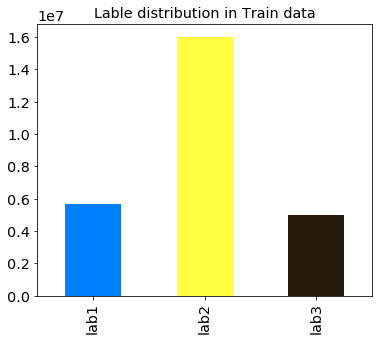

In [259]:
df_train[['lab' +str(i) for i in range(1,4)]].sum().plot(kind='bar', color=my_colors,
                                                   title='Lable distribution in Train data')

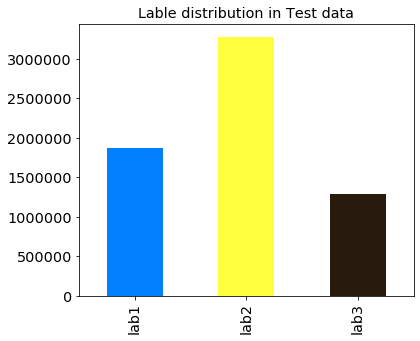

In [260]:
df_test[['lab' +str(i) for i in range(1,4)]].sum().plot(kind='bar', color=my_colors,
                                                   title='Lable distribution in Test data')

## Build Train generator

In [14]:
def get_numpy_img_lbl(img_id = 'BraTS19_TCIA10_449_1', np_dir=NUMPY_DIR):
    img=np.load(os.path.join(np_dir, img_id+'.npy'))
    lbl=np.load(os.path.join(np_dir, img_id+'_lbl.npy'))
    return img,lbl

In [168]:
def get_random_img(axis=0, df=df_train, np_dir=NUMPY_DIR):
    
    ind = randrange(len(df))
    img_id= df.iloc[ind].id
    img,lbl = get_numpy_img_lbl(img_id, np_dir=NUMPY_DIR)
        
    if (axis==0):
        x = randrange(df.iloc[ind].rmin, df.iloc[ind].rmax+1)
        return img[ x,:,:, :], lbl[x,:,:]

    im = np.zeros((240,240,4),dtype=np.float32)    
    lb = np.zeros((240,240),dtype=np.int)
        
    if (axis==1):
        y = randrange(df.iloc[ind].cmin, df.iloc[ind].cmax+1)
        im[40:40+155,:,:]=img[:, y,:, :]
        lb[40:40+155,:]=lbl[:, y,:]
        return im,lb
    
    if (axis == 2):
        z = randrange(df.iloc[ind].zmin, df.iloc[ind].zmax+1)
        im[40:40+155,:,:]=img[:,:, z, :]
        lb[40:40+155,:]=lbl[:,:,z]
        return im,lb
    return None    

<Figure size 432x288 with 0 Axes>

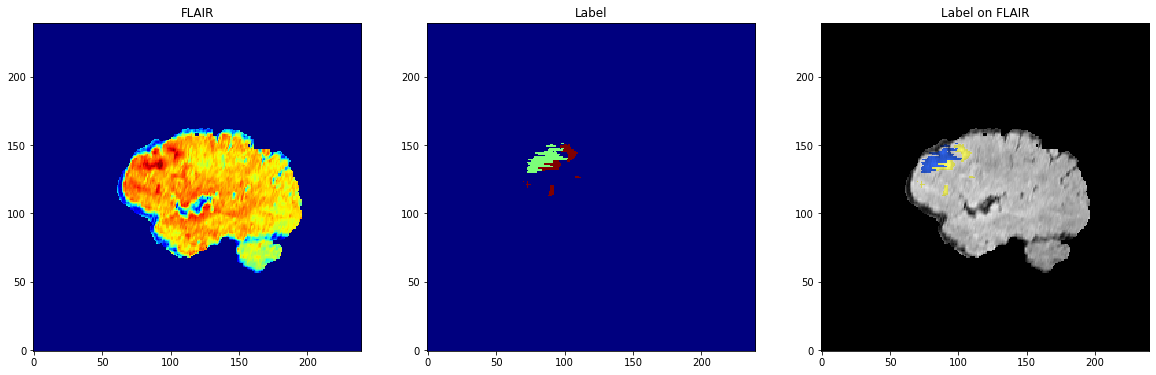

In [169]:
img,lbl = get_random_img(2)
show_img_lable(img, lbl)

Function randomly selects a 2D image that includes the given label

In [170]:
def get_img_for_label(lab=2, axis=0, df=df_train,np_dir = NUMPY_DIR):
    
    img_id= random.choice(df[df['lab'+str(lab)] > 0].id.values)
    
    img,lbl = get_numpy_img_lbl(img_id, np_dir)
    ind = np.where(lbl==lab)
    k = random.randrange(len(ind[0]))
    
    if (axis==0):        
        return img[ind[0][k],:,:] , lbl[ind[0][k],:,:]
        
    lb = np.zeros((240,240),dtype=np.int)
    im = np.zeros((240,240,4),dtype=np.float32)
    
    if (axis==1):
        im[40:40+155,:,:]=img[:, ind[1][k],:,:]
        lb[40:40+155,:]=lbl[:, ind[1][k],:]
        return im,lb
    
    if (axis == 2):
        im[40:40+155,:,:]=img[:, :, ind[2][k],:]
        lb[40:40+155,:]=lbl[:,:,ind[2][k]]
        return im,lb
    return None

<Figure size 432x288 with 0 Axes>

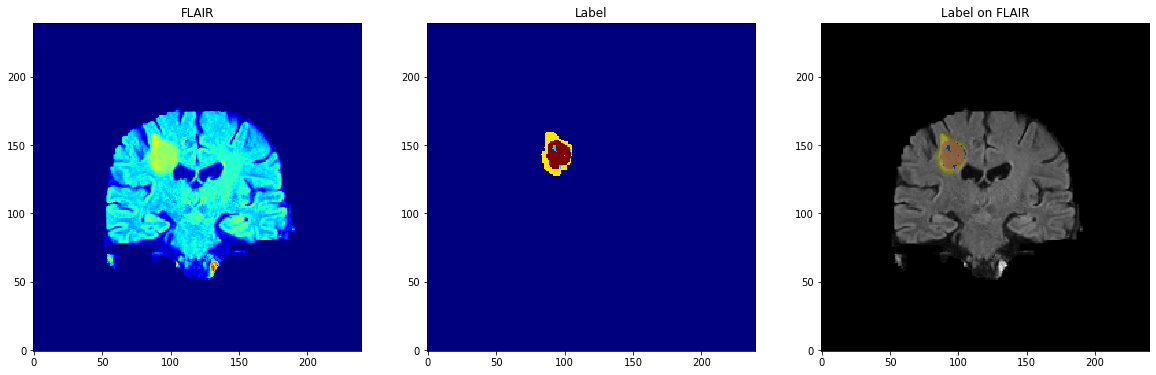

In [171]:
img,lbl = get_img_for_label(1,1)
show_img_lable(img, lbl)

<Figure size 432x360 with 0 Axes>

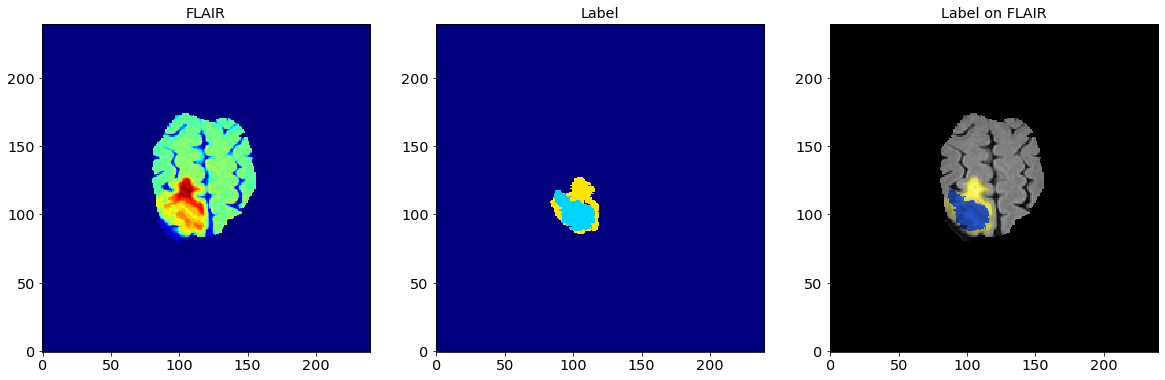

In [174]:
img,lbl = get_img_for_label(3,0)
show_img_lable(img, lbl)

<Figure size 432x360 with 0 Axes>

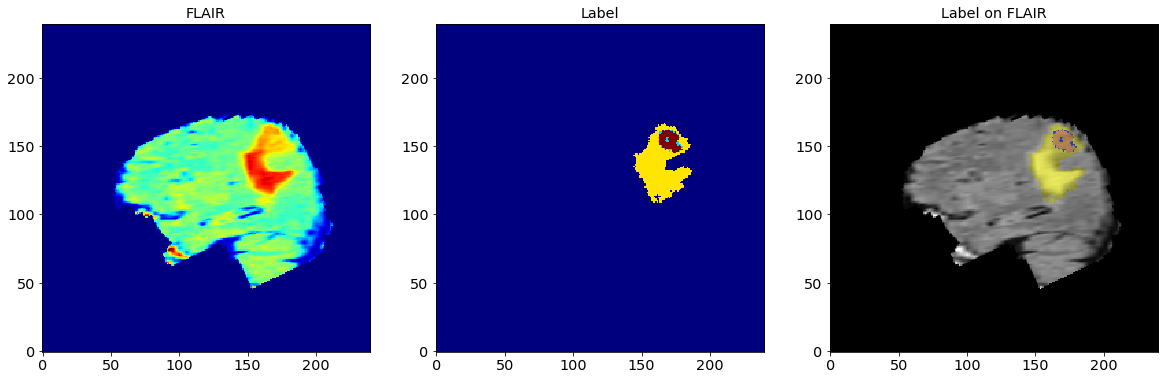

In [175]:
img,lbl = get_img_for_label(2,2)
show_img_lable(img, lbl)

<Figure size 432x360 with 0 Axes>

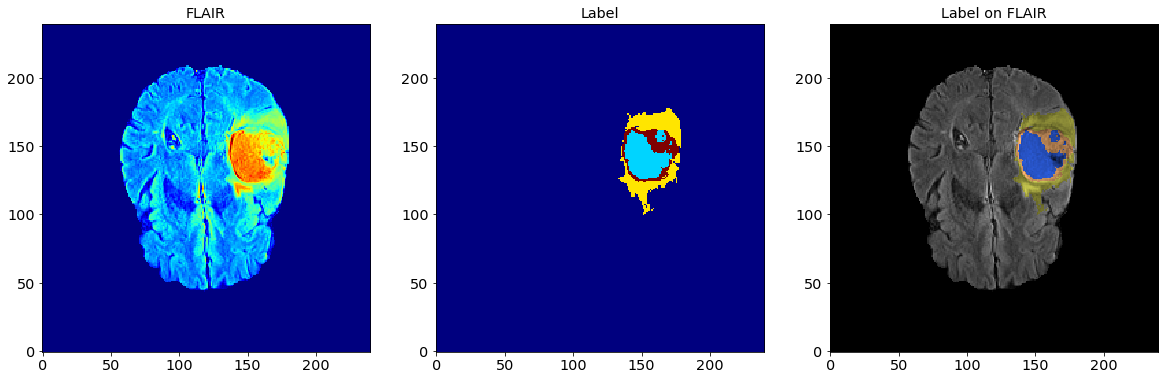

In [176]:
img,lbl = get_img_for_label(1,0)
show_img_lable(img, lbl)

In [177]:
def lbl_from_cat(cat_lbl):
    
    lbl=0
    if (len(cat_lbl.shape)==3):
        for i in range(1,4):
            lbl = lbl + cat_lbl[:,:,i]*i
    elif (len(cat_lbl.shape)==4):
        for i in range(1,4):
            lbl = lbl + cat_lbl[:,:,:,i]*i
    else:
        print('Error in lbl_from_cat', cat_lbl.shape)
        return None
    return lbl

For test we will create batch from few test images. only planes with lables >0 will be included.

In [178]:
def normalize_3D_image(img):
    for z in range(img.shape[0]):
        for k in range(4):
            if (img[z,:,:,k].max()>0):
                img[z,:,:,k] /= img[z,:,:,k].max()
    return img

In [179]:
def normalize_2D_image(img):

        for c in range(4):
            if (img[:,:,c].max()>0):
                img[:,:,c] = img[:,:,c]/img[:,:,c].max()
        return img

Function returns all z-planes of the image that have non-zerolable

In [182]:
def get_img_batch(row, np_dir=NUMPY_DIR):
    
    im,lb = get_numpy_img_lbl(row['id'], np_dir)
    
    n_im = row['rmax']-row['rmin']
    rmin=row['rmin']
    rmax=row['rmax']
    
    return normalize_3D_image(im[rmin:rmax]), np_utils.to_categorical(lb[rmin:rmax],4)

<Figure size 432x360 with 0 Axes>

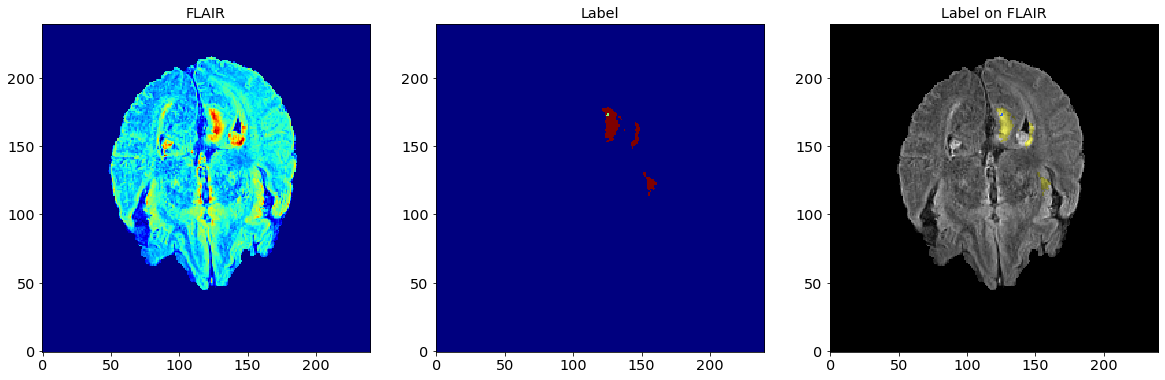

In [188]:
im, lb = get_img_batch(df_test.iloc[0])
im.shape, lb.shape
show_img_lable(im[6], lb[6])

<Figure size 432x360 with 0 Axes>

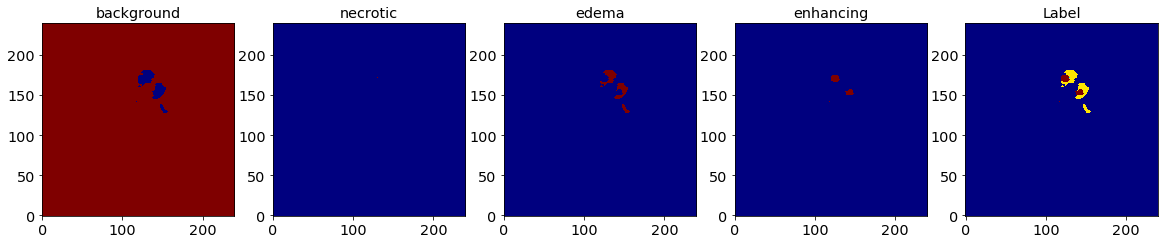

In [203]:
i=15
show_lable(lb[i])

Get images with non-zero labels from all raws of given data frame

In [30]:
def get_df_img_batch(df_batch, np_dir=NUMPY_DIR):
    
        n_images = (df_batch.rmax - df_batch.rmin).sum()
        b_images = np.zeros((n_images, 240, 240, 4), np.float32)
        b_label = np.zeros((n_images, 240, 240, 4), np.int8)    
        ind=0
        for index, row in df_batch.iterrows():
 
            b_im, b_lb = get_img_batch(row, np_dir)
            n_im = b_im.shape[0]
            b_images[ind:ind+n_im] = b_im
            b_label[ind:ind+n_im] = b_lb
            ind+=n_im
               
        return b_images, b_label

<Figure size 432x360 with 0 Axes>

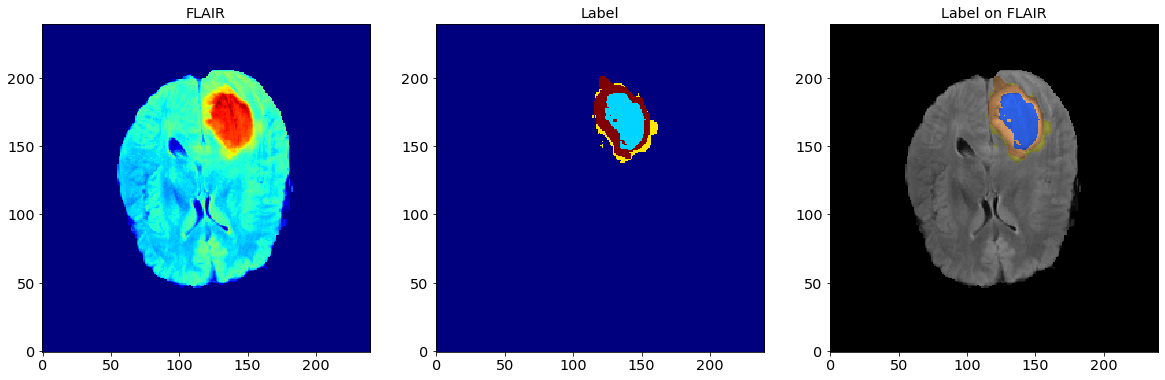

In [205]:
im, lb = get_df_img_batch(df_test.iloc[0:3])
show_img_lable(im[100],lb[100])

Generator for test images

Test the generator,takes
```
CPU times: user 640 ms, sys: 1.3 s, total: 1.94 s
Wall time: 2.72 s
```
3 images, ~251 planes

In [59]:
from keras.utils import np_utils
def generate_im_test_batch(n_images = 3, batch_size=300, df = df_test, np_dir=NUMPY_DIR):

    while 1:
         
        df_batch = df.sample(n_images)
        b_images, b_label = get_df_img_batch(df_batch, np_dir)                    
        b_images, b_label = shuffle(b_images, b_label)
        if (batch_size > 0):
            b_images = b_images[0:batch_size]
            b_label = b_label[0:batch_size]
            
        yield b_images, b_label

In [60]:
%%time
gen_test_im = generate_im_test_batch(5)
imtest,lbtest = next(gen_test_im)
imtest.shape, lbtest.shape

CPU times: user 3.94 s, sys: 10.1 s, total: 14 s
Wall time: 12.7 s


((300, 240, 240, 4), (300, 240, 240, 4))

<Figure size 432x360 with 0 Axes>

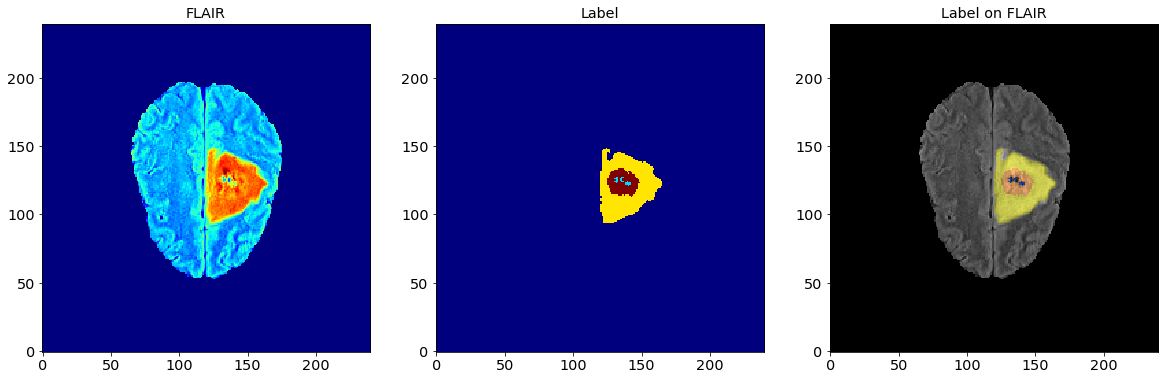

In [206]:
show_img_lable(imtest[100], lbtest[100])

<Figure size 432x360 with 0 Axes>

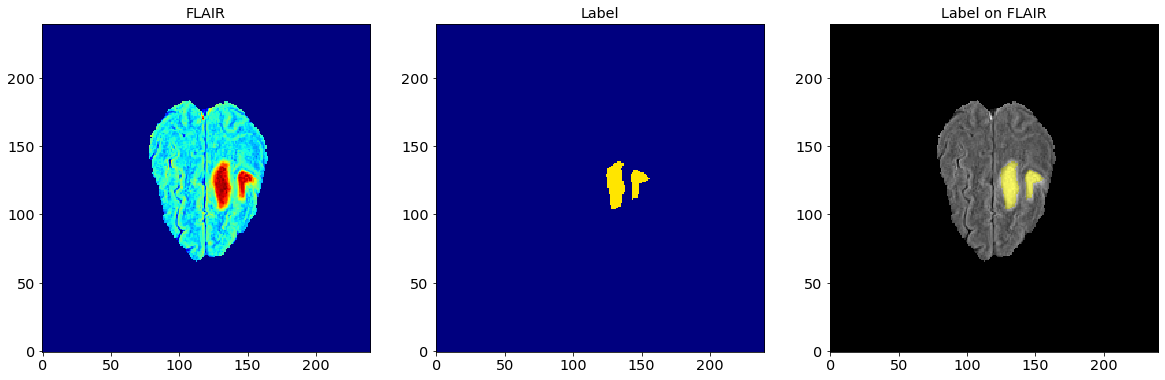

<Figure size 432x360 with 0 Axes>

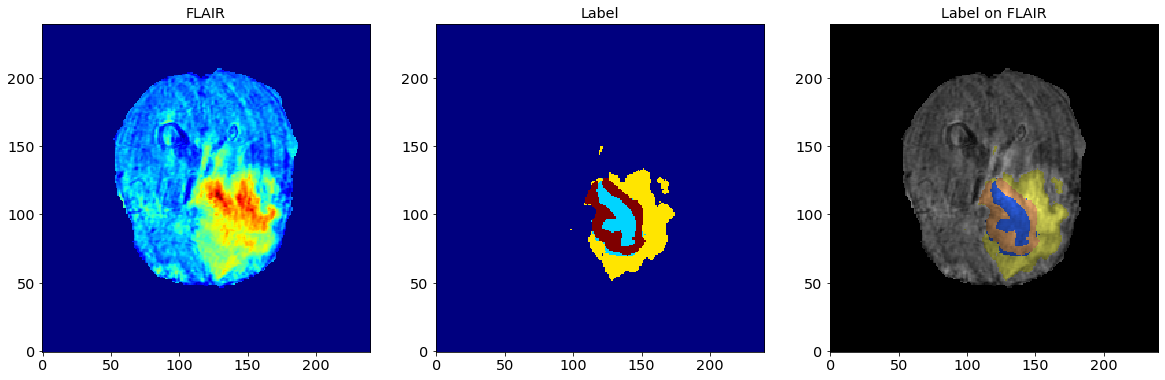

In [208]:
ind=[6,8]
for i in ind:show_img_lable(imtest[i], lbtest[i])

Test the faster generator. Takes:
```
CPU times: user 1.58 s, sys: 6.29 s, total: 7.87 s
Wall time: 12.4 s
```
for 32 batch size

In [209]:
#***
from keras.utils import np_utils
def generate_faste_train_batch(batch_size = 12, df = df_train ,np_dir=NUMPY_DIR):
    
    batch_images = np.zeros((batch_size, 240, 240, 4), np.float32)
    batch_label = np.zeros((batch_size, 240, 240, 4), np.int8)    
    
    # lab1 22%
    # lab2 58%
    # lab3 18%

    while 1:
        
        df_batch = df.sample(3)
        b_images, b_label = get_df_img_batch(df_batch, np_dir)                    
        b_images, b_label = shuffle(b_images, b_label)
        batch_images[0:batch_size//2]=b_images[0:batch_size//2]
        batch_label[0:batch_size//2]=b_label[0:batch_size//2]
        
        i=batch_size//2
        # lab 1
        nim = batch_size//4
        for j in range(nim):
            im,lbl = get_img_for_label(lab=1, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = normalize_2D_image(im)
            batch_label[i] = np_utils.to_categorical(lbl, 4)
            i+=1
                        
        # lab 3
        nim = batch_size//4
        for j in range(nim):
            im,lbl = get_img_for_label(lab=3, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = normalize_2D_image(im)
            batch_label[i] = np_utils.to_categorical(lbl, 4)
            i+=1

        batch_images, batch_label = shuffle(batch_images, batch_label)
            
        yield batch_images, batch_label

In [210]:
%%time
gen_train_fast = generate_faste_train_batch(batch_size=16)
bimg,blbl = next(gen_train_fast)
bimg.shape, blbl.shape

CPU times: user 1.31 s, sys: 4.47 s, total: 5.78 s
Wall time: 16.5 s


((16, 240, 240, 4), (16, 240, 240, 4))

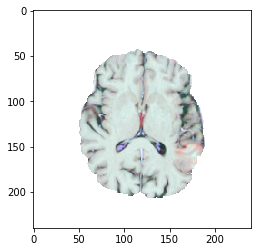

In [42]:
plt.imshow(normalize_2D_image(bimg[8]))

Slower train batch, but more ballanced in labels,

Define train generator and test that it works correctly.
> Takes: 
CPU times: 
user 2.52 s, sys: 12 s, total: 14.5 s
Wall time: 29.2 s
> for batch size 32 

In [211]:
#***

def generate_train_batch(batch_size = 12, df = df_train):
    
    batch_images = np.zeros((batch_size, 240, 240, 4), np.float32)
    batch_label = np.zeros((batch_size, 240, 240, 1), np.int8)    
    
    # lab1 22%
    # lab2 58%
    # lab3 18%

    while 1:
         
        i = 0
        
        # lab 1
        nim = batch_size//4
        for j in range(nim):
            im,lbl = get_img_for_label(lab=1, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = im/im.max()
            batch_label[i,:,:,0] = lbl
            i+=1
            
        
        # lab 2
        nim = batch_size//2
        for j in range(nim):
            im,lbl = get_img_for_label(lab=2, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = im/im.max()
            batch_label[i,:,:,0] = lbl
            i+=1
            
        # lab 3
        nim = batch_size//4
        for j in range(nim):
            im,lbl = get_img_for_label(lab=3, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = im/im.max()
            batch_label[i,:,:,0] = lbl
            i+=1

        # The rest
        nim = batch_size - i
        for j in range(nim):
            im,lbl = get_random_img(axis=random.choice([0,1,2]), df=df)
            batch_images[i] = im/im.max()
            batch_label[i,:,:,0] = lbl
            i+=1
                    
        batch_images, batch_label = shuffle(batch_images, batch_label)
            
        yield batch_images, np_utils.to_categorical(batch_label, 4)

In [212]:
%%time
gen_train = generate_train_batch(batch_size=16)
bimg,blbl = next(gen_train)
bimg.shape, blbl.shape

CPU times: user 1.12 s, sys: 5.7 s, total: 6.83 s
Wall time: 22 s


((16, 240, 240, 4), (16, 240, 240, 4))

<Figure size 432x360 with 0 Axes>

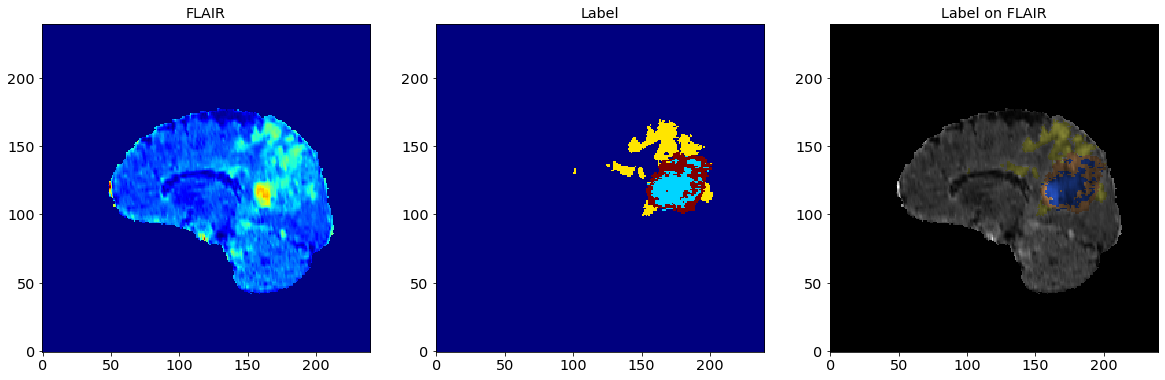

In [213]:
show_img_lable(bimg[i], blbl[i])

Test the generator
```
CPU times: user 2.53 s, sys: 12.4 s, total: 14.9 s
Wall time: 24.7 s
```

In [47]:
%%time
gen_test = generate_train_batch(36,df_test)
bimg,blbl = next(gen_test)
bimg.shape, blbl.shape

CPU times: user 2.58 s, sys: 13.7 s, total: 16.3 s
Wall time: 24.8 s


((36, 240, 240, 4), (36, 240, 240, 4))

<Figure size 432x360 with 0 Axes>

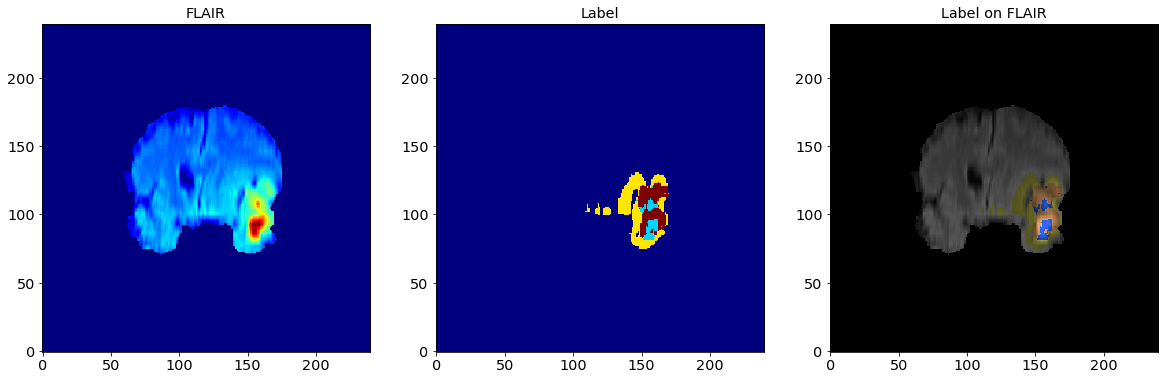

In [214]:
i=6
show_img_lable(bimg[i], blbl[i])

## define Base Unet Model

In [215]:
import tensorflow as tf
from keras import backend as K

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import Input, UpSampling2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [53]:
IMG_HEIGHT=240
IMG_WIDTH = 240
IMG_CHANNELS = 4

In [54]:
import model_unet

model = model_unet.unet(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

In [55]:
model.compile(optimizer = Adam(lr = 0.0001), loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [56]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 120, 120, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [57]:
%%time
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath = 'model_unet_4ch.hdf5',
                               verbose=1,
                               save_best_only=True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001, verbose=1,  cooldown=1)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 115 µs


In [58]:
%%time
history = model.fit_generator(gen_train_fast,
                                        validation_data = gen_test_im, validation_steps=1,
                                              steps_per_epoch=30,
                              epochs=100,
                    callbacks=[earlystopper, checkpointer, reduce_lr])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
30/30 [==============================] - 293s 10s/step - loss: 0.3313 - accuracy: 0.9360 - val_loss: 0.0923 - val_accuracy: 0.9774

Epoch 00001: val_loss improved from inf to 0.09234, saving model to model_unet_4ch.hdf5
Epoch 2/100
30/30 [==============================] - 264s 9s/step - loss: 0.0970 - accuracy: 0.9703 - val_loss: 0.1272 - val_accuracy: 0.9669

Epoch 00002: val_loss did not improve from 0.09234
Epoch 3/100
30/30 [==============================] - 245s 8s/step - loss: 0.0844 - accuracy: 0.9744 - val_loss: 0.0773 - val_accuracy: 0.9749

Epoch 00003: val_loss improved from 0.09234 to 0.07727, saving model to model_unet_4ch.hdf5
Epoch 4/100
30/30 [==============================] - 258s 9s/step - loss: 0.0800 - accuracy: 0.9745 - val_loss: 0.0774 - val_accuracy: 0.9800

Epoch 00004: val_loss did not improve from 0.07727
Epoch 5/100
30/30 [==============================]

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


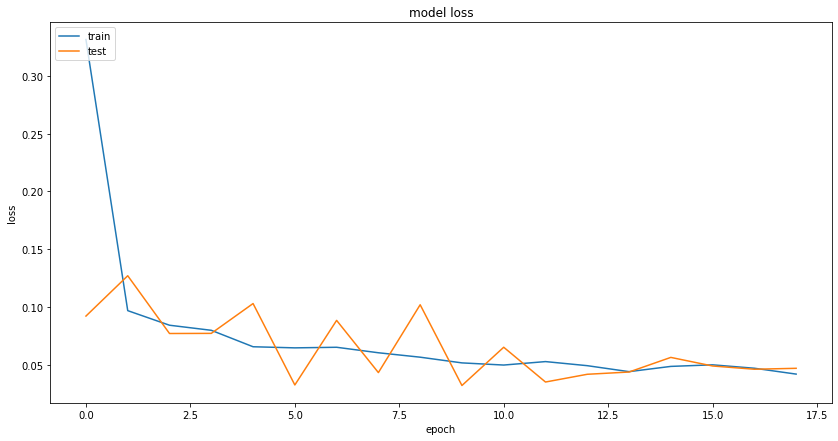

In [80]:
drow_history(history)

In [81]:
model.save_weights('model_unet_ce.hdf5')

In [651]:
model.load_weights('model_unet_4ch.hdf5')

## Predict with trained model

In [ ]:
Function converts probabilities to labels

In [64]:
def get_pred(img, threshold=0.5):
    out_img=img.copy()
    out_img=np.where(out_img>threshold, 1,0)
    return out_img

In [234]:
def prediction_from_probabily_3D(img):
    
    int_image = get_pred(img)
    return lbl_from_cat(int_image)

In [66]:
def get_prediction_for_batch(pred_batch, threshold=0.5):
    
    out_batch = np.zeros((pred_batch.shape[0], 240, 240),dtype=np.int)
    
    for j in range(pred_batch.shape[0]):
        pred = get_prediction(pred_batch[j])
        if (pred.sum()>0):
            print(j, np.unique(pred , return_counts=True))
        out_batch[j] = lbl_from_cat(get_prediction(pred_batch[j]))
    return out_batch  

In [67]:
def get_label_from_pred_batch(labels_batch):
    
    batch = np.zeros((labels_batch.shape[0], 240, 240), np.uint8)
     
    for j in range(labels_batch.shape[0]):
        batch[j]=get_pred(labels_batch[j,:,:,0])+\
                get_pred(labels_batch[j,:,:,1])*2+\
        get_pred(labels_batch[j,:,:,2])*4

    return batch

In [274]:
def predict_3D_img_prob(np_file):
    
    np_img = np.load(np_file)
    for_pred_img = np.zeros((155, 240, 240, 4), np.float32)

    # Normalize image
    for_pred_img = normalize_3D_image(np_img)

    mdl_pred_img =  model.predict(for_pred_img)

    #pred_label = prediction_from_probabily_3D(mdl_pred_img)

    return mdl_pred_img

## Predict on Test images

In [90]:
df_test.head()

,Grade,id,lab0,lab1,lab2,lab3,rmin,rmax,cmin,cmax,zmin,zmax
0,HGG,BraTS19_CBICA_AQJ_1,8840391,6619,58882,22108,55,136,95,201,100,163
1,HGG,BraTS19_TCIA08_162_1,8840807,29581,21267,36345,60,124,124,201,112,163
2,LGG,BraTS19_TCIA10_442_1,8812383,100261,13194,2162,28,100,83,164,50,106
3,HGG,BraTS19_CBICA_BBG_1,8827276,6272,72599,21853,50,130,50,161,118,177
4,LGG,BraTS19_TCIA10_330_1,8850980,50014,23191,3815,31,89,98,175,63,116


In [221]:
img_id = 'BraTS19_2013_18_1'
im,lb = get_numpy_img_lbl(img_id = 'BraTS19_2013_18_1')
im.shape,lb.shape

((155, 240, 240, 4), (155, 240, 240))

In [222]:
nimg = os.path.join(NUMPY_DIR, img_id+'.npy')
pred_stats = predict_3D_img_prob(nimg)
pred_stats.shape

(155, 240, 240, 4)

In [223]:
pred = prediction_from_probabily_3D(pred_stats)
pred.shape

(155, 240, 240)

In [224]:
np.unique(pred)

array([0, 1, 2, 3])

View predicted probabilities, and the resulted labels

<Figure size 432x360 with 0 Axes>

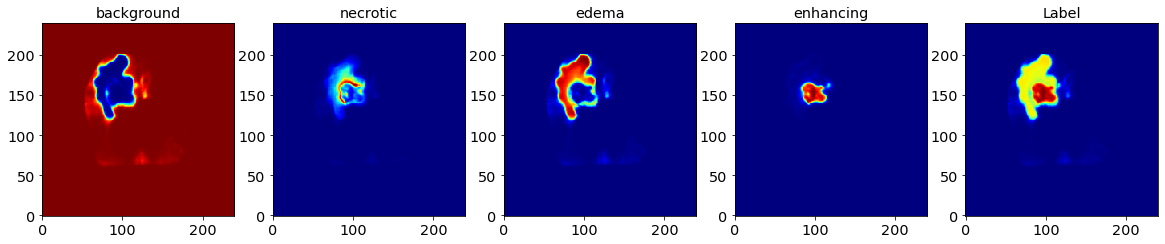

<Figure size 432x360 with 0 Axes>

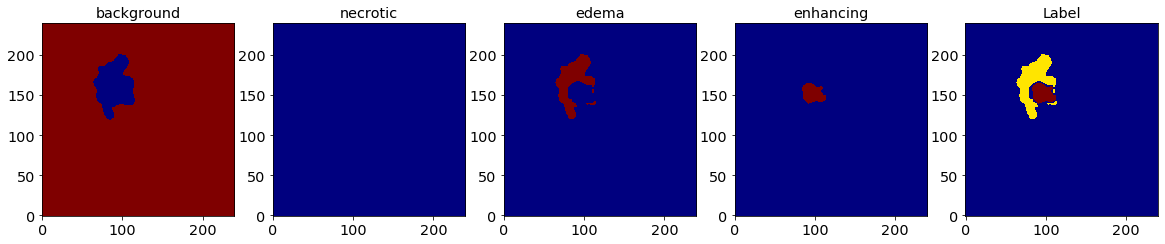

<Figure size 432x360 with 0 Axes>

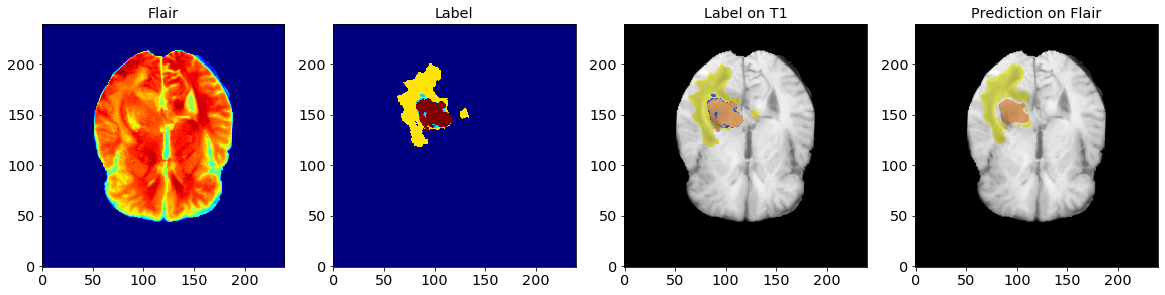

<Figure size 432x360 with 0 Axes>

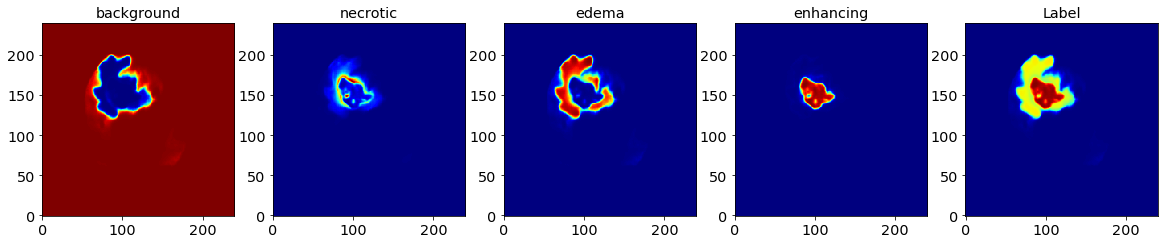

<Figure size 432x360 with 0 Axes>

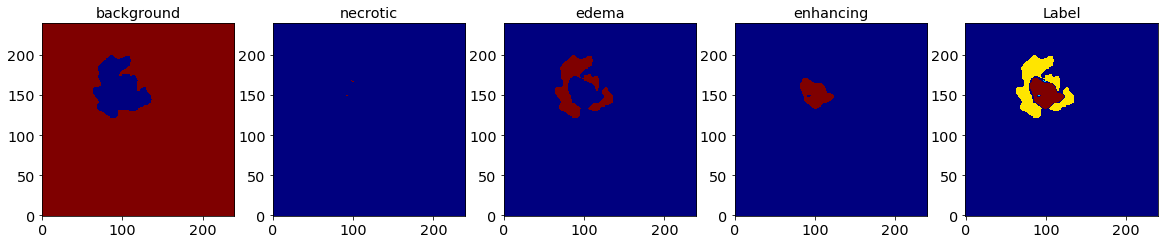

<Figure size 432x360 with 0 Axes>

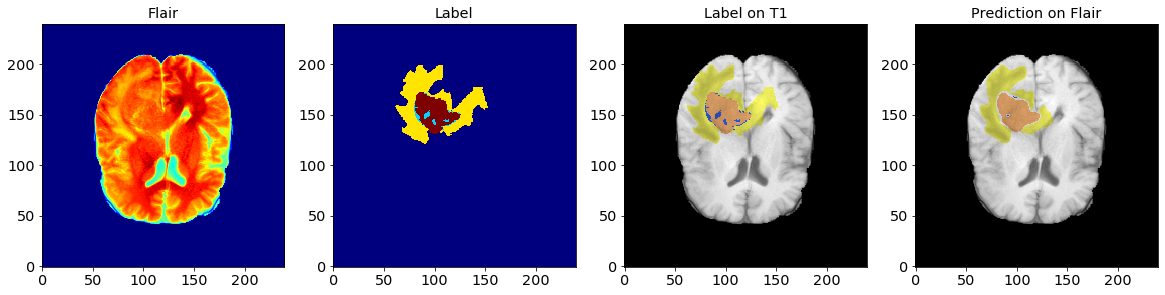

<Figure size 432x360 with 0 Axes>

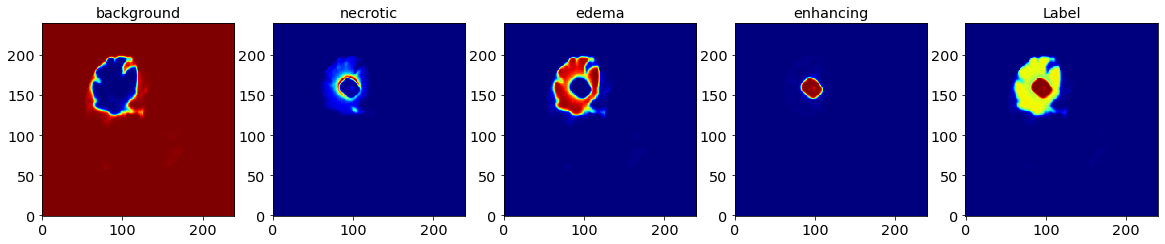

<Figure size 432x360 with 0 Axes>

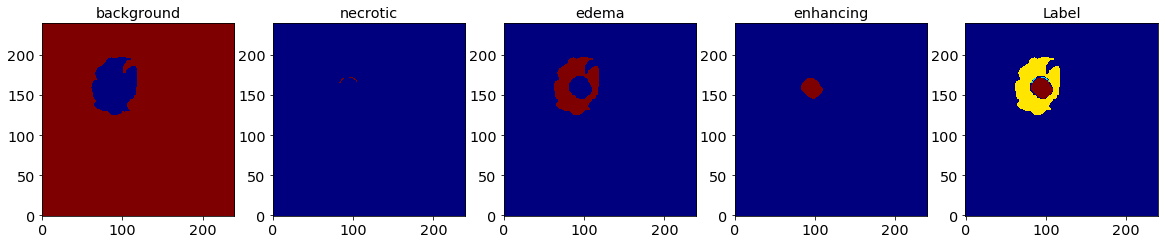

<Figure size 432x360 with 0 Axes>

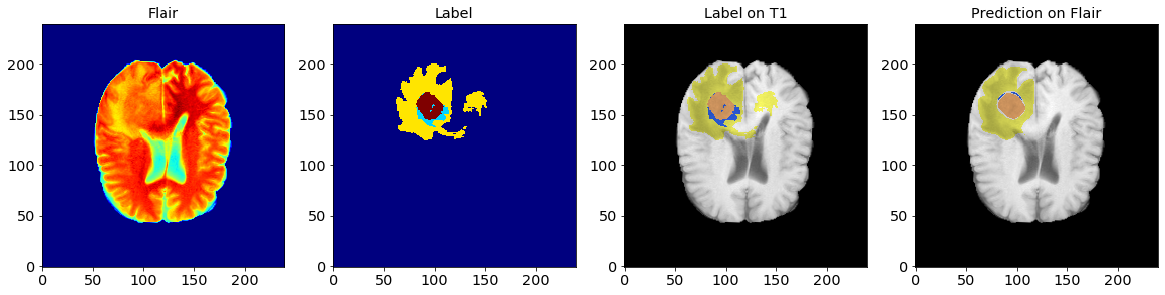

In [233]:
ind=[70,80,90]
for i in ind:
    show_lable(pred_stats[i])
    show_lable(get_pred(pred_stats[i]))
    show_pred_im_lable(im[i], lb[i], pred[i])

## Predict all test images to calculate IOU

In [242]:
! cd /naomi/DATA

In [271]:
! ls /naomi/DATA/MICCAI_BraTS_2019_Data_Validation/numpy_images

BraTS19_CBICA_AAM_1   BraTS19_TCIA02_382_1  BraTS19_TCIA10_647_1
BraTS19_CBICA_ABT_1   BraTS19_TCIA02_400_1  BraTS19_TCIA11_612_1
BraTS19_CBICA_ALA_1   BraTS19_TCIA02_457_1  BraTS19_TCIA12_146_1
BraTS19_CBICA_ALT_1   BraTS19_TCIA02_496_1  BraTS19_TCIA12_339_1
BraTS19_CBICA_ALV_1   BraTS19_TCIA03_216_1  BraTS19_TCIA12_613_1
BraTS19_CBICA_ALZ_1   BraTS19_TCIA03_250_1  BraTS19_TCIA12_641_1
BraTS19_CBICA_AMF_1   BraTS19_TCIA03_288_1  BraTS19_TCIA13_610_1
BraTS19_CBICA_AMU_1   BraTS19_TCIA03_295_1  BraTS19_TCIA13_611_1
BraTS19_CBICA_ANK_1   BraTS19_TCIA03_303_1  BraTS19_TCIA13_616_1
BraTS19_CBICA_APM_1   BraTS19_TCIA03_304_1  BraTS19_TCIA13_617_1
BraTS19_CBICA_AQE_1   BraTS19_TCIA03_313_1  BraTS19_TCIA13_619_1
BraTS19_CBICA_ARR_1   BraTS19_TCIA03_318_1  BraTS19_TCIA13_622_1
BraTS19_CBICA_ATW_1   BraTS19_TCIA03_464_1  BraTS19_TCIA13_626_1
BraTS19_CBICA_AUC_1   BraTS19_TCIA03_604_1  BraTS19_TCIA13_636_1
BraTS19_CBICA_AUE_1   BraTS19_TCIA04_212_1  BraTS19_TCIA13_638_1
BraTS19_CBICA_AZA_1   Bra

In [264]:
!mkdir /naomi/DATA/predictions/pred1/validation/nii

In [248]:
!mkdir /naomi/DATA/predictions/pred1/test/numpy_images

In [266]:
TEST_PRED_NUMPY_DIR = '/naomi/DATA/predictions/pred1/test/numpy_images/'
VALIDATION_PRED_NUMPY_DIR = '/naomi/DATA/predictions/pred1/validation/numpy_images/'
VALIDATION_PRED_NII_DIR = '/naomi/DATA/predictions/pred1/validation/nii/'

Check that its all working -:)

In [250]:
img_id = 'BraTS19_2013_18_1'
im,lb = get_numpy_img_lbl(img_id = 'BraTS19_2013_18_1')
im.shape,lb.shape

nimg = os.path.join(NUMPY_DIR, img_id+'.npy')
pred_stats = predict_3D_img_prob(nimg)
pred_stats.shape

pred = prediction_from_probabily_3D(pred_stats)
pred.shape

(155, 240, 240)

<Figure size 432x360 with 0 Axes>

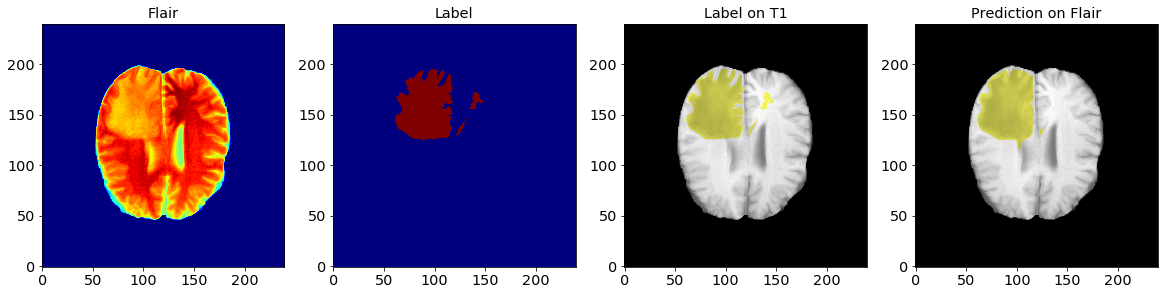

In [252]:
show_pred_im_lable(im[100], lb[100], pred[100])

In [275]:
for index, row in df_test.iterrows():

    img_id = row['id']
    im,lb = get_numpy_img_lbl(img_id = 'BraTS19_2013_18_1')

    nimg = os.path.join(NUMPY_DIR, img_id+'.npy')
    pred_stats = predict_3D_img_prob(nimg)

    pred = prediction_from_probabily_3D(pred_stats)

    out_img = os.path.join(TEST_PRED_NUMPY_DIR, img_id+'_pred.npy')

    np.save(out_img, pred)

FileNotFoundError: [Errno 2] No such file or directory: '/naomi/DATA/MICCAI_BraTS_2019_Data_Validation/numpy_images/BraTS19_CBICA_AQJ_1.npy'

## Predict all validation image

In [268]:
df_val.head()

,id,lab0,lab1,lab2,lab3
0,BraTS19_CBICA_ALA_1,0,0,0,0
1,BraTS19_MDA_1089_1,0,0,0,0
2,BraTS19_TCIA03_250_1,0,0,0,0
3,BraTS19_TCIA13_616_1,0,0,0,0
4,BraTS19_TCIA13_649_1,0,0,0,0


<Figure size 432x360 with 0 Axes>

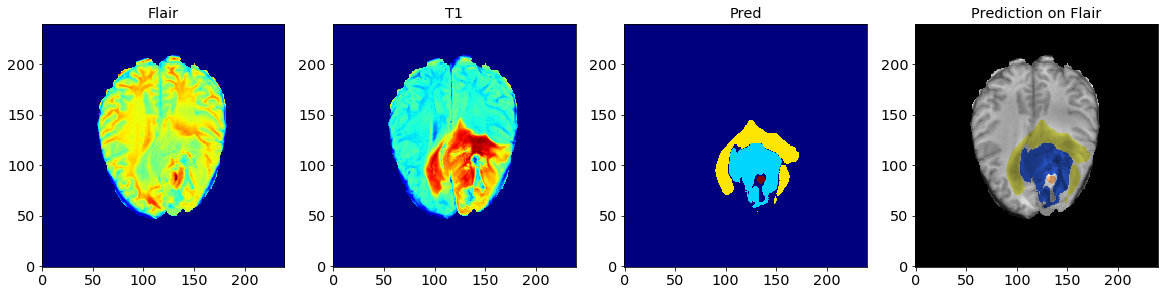

In [279]:
img_id='BraTS19_TCIA13_616_1'
nimg = os.path.join(VALIDATION_NUMPY_DIR, img_id+'.npy')
im = np.load(nimg)
pred_stats = predict_3D_img_prob(nimg)
pred = prediction_from_probabily_3D(pred_stats)
show_pred_im(im[100], pred[100])

In [280]:
for index, row in df_test.iterrows():

    img_id = row['id']

    nimg = os.path.join(NUMPY_DIR, img_id+'.npy')
    pred_stats = predict_3D_img_prob(nimg)

    pred = prediction_from_probabily_3D(pred_stats)

    out_img = os.path.join(TEST_PRED_NUMPY_DIR, img_id+'_pred.npy')

    np.save(out_img, pred)
    
    out_nii = os.path.join(VALIDATION_PRED_NII_DIR, img_id+'.nii.gz')

    sitk_img = sitk.GetImageFromArray(pred)
    sitk.WriteImage(sitk_img, out_nii)